In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from itertools import product
from functools import reduce

## Data preparation

In [3]:
MUST_HAVE_LABELS = ("endemic", "non_case")
DATA_LABELS = ("one", "two", "three") + MUST_HAVE_LABELS

In [4]:
class Score:
    def __init__(self, data, signals, data_labels, missing_signal_agg="mean"):
        self.MUST_HAVE_LABELS = {"endemic", "non_case"}
        self.DATA_LABELS = list(set(data_labels) | self.MUST_HAVE_LABELS)

        self.data = self._pad_non_case(data)
        self.signals = self._pad_signals(
            pd.merge(self.data, signals, on=["x1", "x2"]), missing_signal_agg
        )
        self.SIGNALS_LABELS = list(
            self.signals.columns[self.signals.columns.str.contains("^w")]
        )
        self.COORDS = list(data.columns[data.columns.str.contains("^x")])

    def _pad_non_case(self, data):
        if data["non_case"].isna().any():
            is_non_case = data.loc[:, list(self.DATA_LABELS)].sum(axis=1) == 0
            return data.assign(non_case=np.where(is_non_case, 1, 0))
        else:
            return data

    def _pad_signals(self, signals, aggregation_func):
        """
        Calculates signals for endemic and non cases.

        Input DataFrame must indicate signal columns with 'w_' in their name.
        """
        if not any((signals["endemic"] > 0) & (signals["non_case"] > 0)):
            signal_columns = [c for c in signals.columns if "w_" in c]
            signal_df = signals.copy()

            for signal in signal_columns:
                signal_df.loc[:, f"_{signal}_endemic"] = (
                    1 - signal_df.loc[:, signal]
                ) * (signal_df["non_case"] == 0)
                signal_df.loc[:, f"_{signal}_non_case"] = (
                    1 - signal_df.loc[:, signal]
                ) * (signal_df["non_case"] != 0)

            non_case_signals = signal_df.columns[
                signal_df.columns.str.contains(r"w_._non_case")
            ]
            endemic_signals = signal_df.columns[
                signal_df.columns.str.contains(r"w_._endemic")
            ]

            signal_df.loc[:, "w_non_case"] = signal_df[non_case_signals].agg(
                aggregation_func, axis=1
            )
            signal_df.loc[:, "w_endemic"] = signal_df[endemic_signals].agg(
                aggregation_func, axis=1
            )
            return signal_df
        else:
            return signals

    def plot_map(self, series, title):
        df = self.signals.melt(
            id_vars=self.COORDS,
            value_vars=self.SIGNALS_LABELS,
            var_name="signal",
            value_name="w",
        )
        ax = sns.heatmap(
            series.values.reshape(5, -1).T,
            linewidth=2,
            cmap="RdPu",
            cbar=False,
            annot=True,
        )
        cmap = dict(zip(df.signal.unique(), sns.color_palette("tab10")))
        for _, (x1, x2, signal, value) in df.iterrows():
            if signal not in ("w_endemic", "w_non_case"):
                ax.add_patch(
                    Rectangle(
                        (x1, x2),
                        1,
                        1,
                        fill=False,
                        lw=3,
                        alpha=value,
                        label=signal,
                        color=cmap[signal],
                    )
                )
        ax.set_title(title)
        ax.set_ylim(0, 5)
        ax.set_xlim(0, 5)
        return ax

    def p_di_given_x(self):
        """Calculate disease probability per cell, p(d_i| x)"""
        disease_proba_df = self.data.copy()
        disease_proba_df.loc[:, self.DATA_LABELS] = disease_proba_df.loc[
            :, self.DATA_LABELS
        ].div(disease_proba_df.loc[:, self.DATA_LABELS].sum(axis=1), axis=0)
        return disease_proba_df.melt(
            id_vars=["x1", "x2"], var_name="d_i", value_name="p(d_i)"
        )

    def p_hat_sj_given_x(self):
        """p^ (s_j|x) = w(s, x) / sum_s (w(s,x))"""
        df_prior_signal = self.signals.copy()

        prior_columns = [col.replace("w", "p") for col in self.SIGNALS_LABELS]
        sj_given_x = (
            df_prior_signal.loc[:, self.SIGNALS_LABELS]
            .div(
                df_prior_signal.loc[:, self.SIGNALS_LABELS].sum(axis=1),
                axis=0,
            )
            .values
        )

        df_prior_signal.loc[:, prior_columns] = sj_given_x

        signals_long = df_prior_signal.melt(
            id_vars=self.COORDS,
            value_vars=prior_columns,
            var_name="s_j_given_x",
            value_name="prior",
        ).assign(s_j=lambda x: x["s_j_given_x"].str.replace("p_", ""))
        return signals_long

    def p_hat_di_given_sj_x(self):
        """Calculates p^(d_i | s_j, x) which is algo based."""
        signal_per_diseases = list(
            product(
                product(range(5), range(5)),
                product(
                    self.DATA_LABELS,
                    [col.replace("w_", "") for col in self.SIGNALS_LABELS],
                ),
            )
        )
        df = pd.DataFrame(
            [tuple_[0] + tuple_[1] for tuple_ in signal_per_diseases],
            columns=["x1", "x2", "d_i", "s_j"],
        )

        signal_data_indeces = df.query(
            "~(s_j.isin(['endemic', 'non_case']) | d_i.isin(['endemic', 'non_case']))"
        ).index
        df.loc[signal_data_indeces, "posterior"] = 1 / len(
            set(self.DATA_LABELS) - set(self.MUST_HAVE_LABELS)
        )

        non_case_endemic_signal_indeces = df.query("d_i == s_j").index
        df.loc[non_case_endemic_signal_indeces, "posterior"] = 1
        return df.fillna(0)

    def p_hat_di(self):
        """Calculates p^(d_i | x) = sum( p^(d_i| s_j, x) p^(s_j, x) )"""
        p_hat_di = self.p_hat_di_given_sj_x().merge(
            self.p_hat_sj_given_x(),
            on=self.COORDS + ["s_j"],
        )
        p_hat_di.loc[:, "p^(d_i)"] = p_hat_di["posterior"] * p_hat_di["prior"]
        p_hat_di = (
            p_hat_di.groupby(["x1", "x2", "d_i"]).agg({"p^(d_i)": sum}).reset_index()
        )
        return p_hat_di

    def eval_df(self):
        return self.p_di_given_x().merge(
            self.p_hat_di(),
            on=self.COORDS + ["d_i"],
        )

In [5]:
# define coordinate system with two axes x1 and x2
df_coordinates = pd.concat(
    [
        pd.DataFrame(columns=["x1", "x2"], data=product(range(5), range(5))),
        pd.DataFrame(columns=DATA_LABELS),
    ]
)

In [6]:
# read in data
one = [0] * 5 + [0, 1, 1, 0, 0] + [0, 0, 1, 0, 0] + [0] * 10
two = (
    [
        0,
        0,
        1,
        1,
        1,
    ]
    + [0] * 10
    + [0, 0, 0, 1, 0]
    + [0] * 5
)
three = [0] * 15 + [0, 0, 0, 1, 2] + [0] * 5
endemic = (
    [0] * 5 + [1, 0, 0, 0, 0] + [0, 1, 0, 0, 0] + [4, 0, 0, 0, 1] + [2, 0, 0, 0, 1]
)

df_cases = df_coordinates.assign(one=one, two=two, three=three, endemic=endemic)

In [7]:
df_cases.head()

,x1,x2,one,two,three,endemic,non_case
0,0.0,0.0,0,0,0,0,NaN
1,0.0,1.0,0,0,0,0,NaN
2,0.0,2.0,0,1,0,0,NaN
3,0.0,3.0,0,1,0,0,NaN
4,0.0,4.0,0,1,0,0,NaN


## Signal creation

In [8]:
def run_algo_A(df_coordinates):
    assert len(df_coordinates) == 25
    signale = pd.DataFrame(
        {
            "x1": [1, 1, 2, 2, 3, 4],
            "x2": [1, 2, 1, 2, 0, 0],
            "w_A": [1, 1, 1, 1, 0.5, 0.5],
        }
    )
    signale = df_coordinates.loc[:, ["x1", "x2"]].merge(
        signale, how="left", on=["x1", "x2"]
    )
    return signale.fillna(0)


def run_algo_B(df_coordinates):
    assert len(df_coordinates) == 25
    signale = pd.DataFrame(
        {
            "x1": [2, 2, 2, 3, 3, 3, 4, 4, 4],
            "x2": [2, 3, 4, 2, 3, 4, 2, 3, 4],
            "w_B": [0.5] * 9,
        }
    )
    signale = df_coordinates.loc[:, ["x1", "x2"]].merge(
        signale, how="left", on=["x1", "x2"]
    )
    return signale.fillna(0)


def run_algo_C(df_coordinates):
    assert len(df_coordinates) == 25
    signale = pd.DataFrame({"x1": [0], "x2": [4], "w_C": [1]})
    signale = df_coordinates.loc[:, ["x1", "x2"]].merge(
        signale, how="left", on=["x1", "x2"]
    )
    return signale.fillna(0)

In [9]:
# create signals
signal_A = run_algo_A(df_coordinates)
signal_B = run_algo_B(df_coordinates)
signal_C = run_algo_C(df_coordinates)

signals_without_endemic_non_case = reduce(
    lambda l, r: pd.merge(l, r, on=["x1", "x2"]),
    [signal_A, signal_B, signal_C],
)

signals_without_endemic_non_case.head()

,x1,x2,w_A,w_B,w_C
0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,2.0,0.0,0.0,0.0
3,0.0,3.0,0.0,0.0,0.0
4,0.0,4.0,0.0,0.0,1.0


### Calculate signal for endemic and non-case when not given by algo

<AxesSubplot:title={'center':'endemic_mean'}>

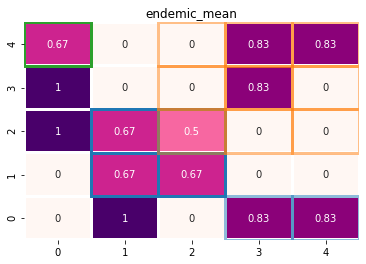

In [10]:
s = Score(df_cases, signals_without_endemic_non_case, ["one", "two", "three"])

s.plot_map(
    s.signals.w_endemic,
    "endemic_mean",
)

## Score calculation (regression)

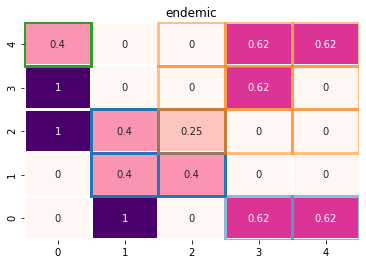

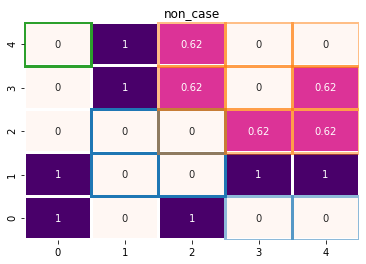

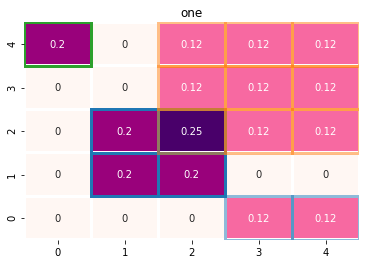

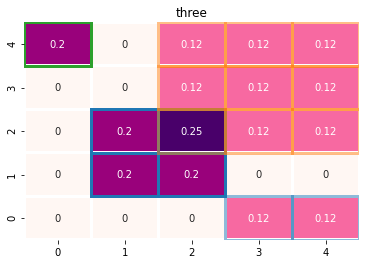

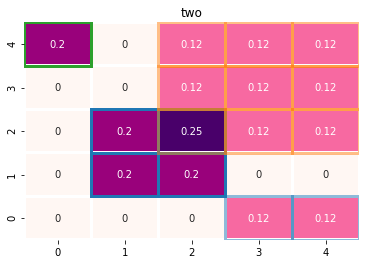

In [11]:
for datalabel in s.p_hat_di().d_i.unique():
    s.plot_map(s.p_hat_di().query("d_i==@datalabel").loc[:, ["p^(d_i)"]], datalabel)
    plt.show()

In [12]:
def KL(P, Q):
    """Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0."""
    epsilon = 0.00001

    P = P + epsilon
    Q = Q + epsilon

    divergence = np.sum(P * np.log(P / Q))
    return divergence

In [13]:
print("KL")
print(KL(s.eval_df()["p(d_i)"].values / 25, s.eval_df()["p^(d_i)"].values / 25))

KL
1.1879392914261868


In [14]:
from scipy.stats import entropy, mannwhitneyu, pearsonr, wilcoxon
from sklearn import metrics

In [15]:
print("KL form scikitlearn")
print(entropy(s.eval_df()["p(d_i)"].values, s.eval_df()["p^(d_i)"].values + 0.00001))

KL form scikitlearn
1.4484083815323732


In [16]:
print("mutual information")
print(
    metrics.mutual_info_score(
        s.eval_df()["p(d_i)"].values, s.eval_df()["p^(d_i)"].values
    )
)

mutual information
0.3025208486903207


In [17]:
print("regression score")
print(metrics.r2_score(s.eval_df()["p(d_i)"].values, s.eval_df()["p^(d_i)"].values))

regression score
0.45069970845481055


In [18]:
print("RMSE")
print(
    np.sqrt(
        np.mean((s.eval_df()["p(d_i)"].values - s.eval_df()["p^(d_i)"].values) ** 2)
    )
)

RMSE
0.2893748050155331


In [19]:
print("MSE")
print(np.mean((s.eval_df()["p(d_i)"].values - s.eval_df()["p^(d_i)"].values) ** 2))

MSE
0.0837377777777778


In [20]:
print("Correlation")
print(pearsonr(s.eval_df()["p(d_i)"].values, s.eval_df()["p^(d_i)"].values))

Correlation
(0.6755581314500057, 5.5350859638944124e-18)


In [21]:
print("Signed-Wilcoxon")
print(
    wilcoxon(
        s.eval_df()["p(d_i)"].values,
        s.eval_df()["p^(d_i)"].values,
        alternative="two-sided",
    )
)

Signed-Wilcoxon
WilcoxonResult(statistic=923.0, pvalue=0.4292977279173873)


In [22]:
print("U-test")
print(
    mannwhitneyu(
        s.eval_df()["p(d_i)"].values,
        s.eval_df()["p^(d_i)"].values,
        alternative="two-sided",
    )
)

U-test
MannwhitneyuResult(statistic=5881.0, pvalue=0.00011438066880481344)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier

X, y = make_multilabel_classification(random_state=0)
inner_clf = LogisticRegression(solver="liblinear", random_state=0)
clf = MultiOutputClassifier(inner_clf).fit(X, y)
y_score = np.transpose([y_pred[:, 1] for y_pred in clf.predict_proba(X)])
roc_auc_score(y, y_score, average=None)

array([0.82664884, 0.86034414, 0.94181818, 0.8502652 , 0.94809095])

### Confusion Matrix

In [24]:
s.eval_df()

,x1,x2,d_i,p(d_i),p^(d_i)
0,0.0,0.0,one,0.0,0.000
1,0.0,1.0,one,0.0,0.000
2,0.0,2.0,one,0.0,0.000
3,0.0,3.0,one,0.0,0.000
4,0.0,4.0,one,0.0,0.200
...,...,...,...,...,...
120,4.0,0.0,non_case,0.0,0.000
121,4.0,1.0,non_case,1.0,1.000
122,4.0,2.0,non_case,1.0,0.625
123,4.0,3.0,non_case,1.0,0.625


In [25]:
eval_df_mean = s.eval_df()

In [26]:
eval_df_mean.loc[:, "true"] = np.where(
    eval_df_mean.loc[:, "p(d_i)"] >= len(MUST_HAVE_LABELS), 1, 0
)
eval_df_mean.loc[:, "pred"] = np.where(
    eval_df_mean.loc[:, "p^(d_i)"] >= 1 / len(DATA_LABELS), 1, 0
)
pivot_eval = eval_df_mean.pivot(
    index=["x1", "x2"], columns="d_i", values=["true", "pred"]
)

In [27]:
pivot_eval_r = eval_df_mean.pivot(
    index=["x1", "x2"], columns="d_i", values=["p(d_i)", "p^(d_i)"]
)

In [28]:
rel_cm = (
    pivot_eval_r.loc[:, "p(d_i)"]
    .reset_index()
    .melt(id_vars=["x1", "x2"], value_name="p(d_i)")
    .merge(pivot_eval_r.loc[:, "p^(d_i)"].reset_index(), on=["x1", "x2"], how="left")
    .assign(
        endemic=lambda x: x["p(d_i)"] * x["endemic"],
        non_case=lambda x: x["p(d_i)"] * x["non_case"],
        one=lambda x: x["p(d_i)"] * x["one"],
        two=lambda x: x["p(d_i)"] * x["two"],
        three=lambda x: x["p(d_i)"] * x["three"],
    )
    .groupby("d_i")
    .agg(dict(zip(["endemic", "non_case", "one", "three", "two"], ["sum"] * 5)))
)

In [29]:
rel_cm

,endemic,non_case,one,three,two
d_i,,,,,
endemic,3.483333,0.000,0.616667,0.616667,0.616667
non_case,0.000000,10.125,0.625000,0.625000,0.625000
one,1.050000,0.000,0.650000,0.650000,0.650000
three,0.729167,0.000,0.145833,0.145833,0.145833
two,2.712500,0.000,0.262500,0.262500,0.262500


In [30]:
rel_cm.loc[
    [c for c in rel_cm.columns if c != "one"], [c for c in rel_cm.columns if c != "one"]
].sum().sum()

20.349999999999998

In [31]:
pd.DataFrame(
    {
        "true_pred": [
            rel_cm.loc["one", "one"],
            rel_cm.loc[[c for c in rel_cm.columns if c != "one"], "one"].sum(),
        ],
        "false_pred": [
            rel_cm.loc["one", [c for c in rel_cm.columns if c != "one"]].sum(),
            rel_cm.loc[
                [c for c in rel_cm.columns if c != "one"],
                [c for c in rel_cm.columns if c != "one"],
            ]
            .sum()
            .sum(),
        ],
    },
    index=["true_groundtruth", "false_groundtruth"],
)

,true_pred,false_pred
true_groundtruth,0.65,2.35
false_groundtruth,1.65,20.35


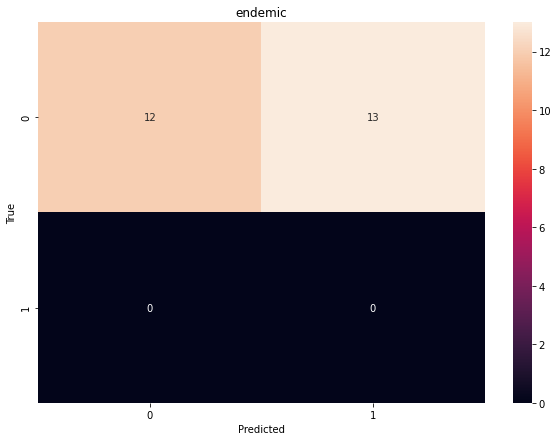

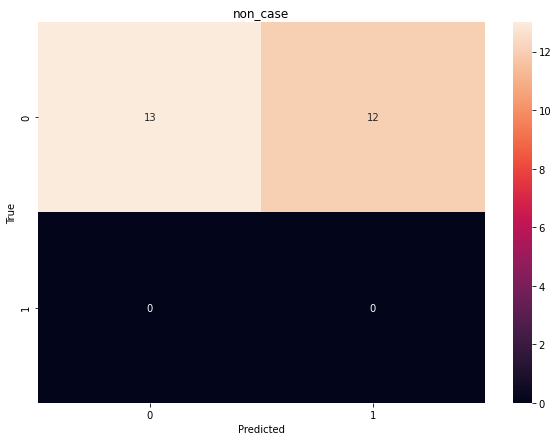

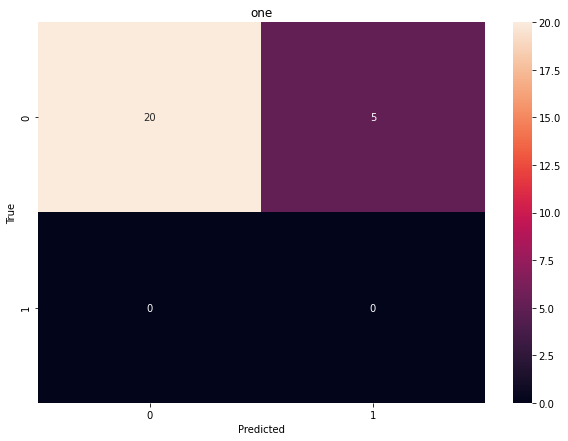

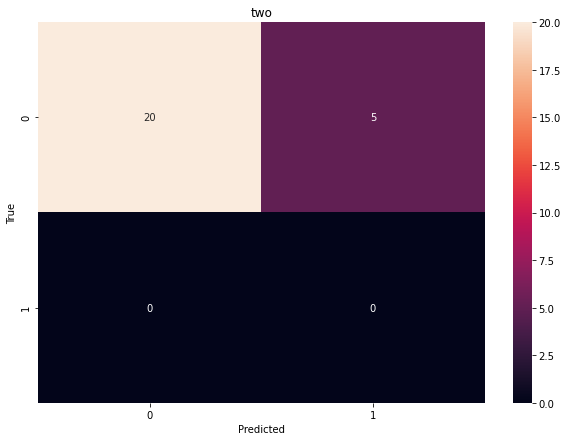

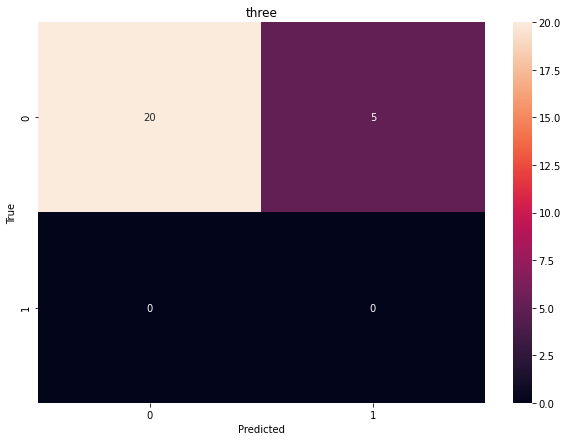

In [32]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix

cm = multilabel_confusion_matrix(
    pivot_eval.loc[:, "true"].values, pivot_eval.loc[:, "pred"].values
)
for i, label in enumerate(["endemic", "non_case", "one", "two", "three"]):
    df_cm = pd.DataFrame(cm[i], index=["0", "1"], columns=["0", "1"])
    plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm, annot=True).set(title=label, ylabel="True", xlabel="Predicted")

In [33]:
for label in ["endemic", "non_case", "one", "two", "three"]:
    print(label)
    print(
        classification_report(
            pivot_eval.loc[:, ("true", label)].values,
            pivot_eval.loc[:, ("pred", label)].values,
        )
    )
    print("******\n\n\n")

endemic
              precision    recall  f1-score   support

           0       1.00      0.48      0.65        25
           1       0.00      0.00      0.00         0

    accuracy                           0.48        25
   macro avg       0.50      0.24      0.32        25
weighted avg       1.00      0.48      0.65        25

******



non_case
              precision    recall  f1-score   support

           0       1.00      0.52      0.68        25
           1       0.00      0.00      0.00         0

    accuracy                           0.52        25
   macro avg       0.50      0.26      0.34        25
weighted avg       1.00      0.52      0.68        25

******



one
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        25
           1       0.00      0.00      0.00         0

    accuracy                           0.80        25
   macro avg       0.50      0.40      0.44        25
weighted avg       1.00      0.80

C:\Users\AbboodA\AppData\Local\Continuum\miniconda3\envs\scoring\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
for label in ["endemic", "non_case", "one", "two", "three"]:
    eval_df_mean.loc[:, "true"] = eval_df_mean.loc[:, "p(d_i)"]
    eval_df_mean.loc[:, "pred_true"] = np.where(
        eval_df_mean.loc[:, "p^(d_i)"] > 0.5, 1, 0
    )
    pivot_eval = eval_df_mean.pivot(
        index=["x1", "x2"], columns="d_i", values=["true", "pred_true"]
    )
    print(label)
    print(
        eval_df_mean.query(f"d_i=='{label}'")
        .assign(false=lambda x: 1 - x["true"])
        .assign(pred_false=lambda x: 1 - x["pred_true"])
        .drop(columns="pred")
        .assign(
            true_positive=lambda x: x["true"] * x["pred_true"],
            true_negative=lambda x: x["false"] * x["pred_false"],
            false_positive=lambda x: x["false"] * x["pred_true"],
            false_negative=lambda x: x["true"] * x["pred_false"],
        )
        .sum()
        .iloc[-4:]
    )
    print("\n")

endemic
true_positive     4.33333
true_negative          16
false_positive    3.66667
false_negative          1
dtype: object


non_case
true_positive     12
true_negative     13
false_positive     0
false_negative     0
dtype: object


one
true_positive      0
true_negative     22
false_positive     0
false_negative     3
dtype: object


two
true_positive        0
true_negative     21.5
false_positive       0
false_negative     3.5
dtype: object


three
true_positive           0
true_negative     23.8333
false_positive          0
false_negative    1.16667
dtype: object




### How to score when algo is a classifier
- We look into data distribution and set a cut-off based on data distribution. We assume that the non-outbreak numbers are highest around 0. This peak will flatten when we move away from 0. There we set a cut-off when the next peak is about to start (probably a outbreak cluster)
- Discretize p(d_i) into bins and predict vector of bins
- p(d_i) \element of {0,1} -> confusion matrix

R = [0,1]

B = {0,1}
- p \element R AND p^ \element R -> like the lower, when threshold for p^ is set to e.g., 0.5
- p \element R AND p^ \element B ->
- p \element B AND p^ \element R -> easy/known/ROC/AUC
- p \element B AND p^ \element B -> easy

### References
- KL, Entropy, MI (Wie macht es inhatlich Sinn die Entropie zu berechnen, gegeben den verschiedenen Zellen und DataLabels)
    - Referenz: https://arxiv.org/pdf/1802.03446.pdf
    - Referenz: https://www.sciencedirect.com/science/article/pii/S107731420700077X (pixel-based classifications)
    - Referenz: https://iopscience.iop.org/article/10.1088/1755-1315/47/1/012042/pdf (pixel-based classifications)
    - Likelihood methoden anschauen
    - https://en.wikipedia.org/wiki/Kernel_embedding_of_distributions

## TODO:    
- Classifikations-Fall (Wie komme ich von einem kontinuierlichen Wert der Daten auf einen binären
    - simplere Beispiele (ein perfektes, ein komplett missklassifiziertes, ein 50/50 Beispiel)
## Backlog:
- z-score-based binning (https://core.ac.uk/download/pdf/82692314.pdf)
    - in general quantiles
- attribute cell to data with highest probability

In [45]:
signals_without_endemic_non_case

,x1,x2,w_A,w_B,w_C
0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,2.0,0.0,0.0,0.0
3,0.0,3.0,0.0,0.0,0.0
4,0.0,4.0,0.0,0.0,1.0
5,1.0,0.0,0.0,0.0,0.0
6,1.0,1.0,1.0,0.0,0.0
7,1.0,2.0,1.0,0.0,0.0
8,1.0,3.0,0.0,0.0,0.0
9,1.0,4.0,0.0,0.0,0.0


In [50]:
signal_bad = pd.DataFrame(product(range(5), range(5)), columns=["x1", "x2"]).assign(
    w_A=0, w_B=0, w_C=0
)

score_bad = Score(df_cases, signal_bad, ["one", "two", "three"])

print("mutual information")
print(
    metrics.mutual_info_score(
        score_bad.eval_df()["p(d_i)"].values, score_bad.eval_df()["p^(d_i)"].values
    )
)

mutual information
0.19305514293545187


In [52]:
signal_sensitive = pd.DataFrame(
    product(range(5), range(5)), columns=["x1", "x2"]
).assign(w_A=1, w_B=1, w_C=1)

score_sensitive = Score(df_cases, signal_sensitive, ["one", "two", "three"])

print("mutual information")
print(
    metrics.mutual_info_score(
        score_sensitive.eval_df()["p(d_i)"].values,
        score_sensitive.eval_df()["p^(d_i)"].values,
    )
)

mutual information
0.07215379222183908


In [68]:
signal_specific = df_cases.assign(
    w_A=lambda x: np.where(x.endemic == 0, x.one, x.one / (x.one + x.endemic)),
    w_B=lambda x: np.where(x.endemic == 0, x.two, x.two / (x.two + x.endemic)),
    w_C=lambda x: np.where(x.endemic == 0, x.three, x.three / (x.three + x.endemic)),
).drop(["one", "two", "three", "endemic", "non_case"], axis=1)

score_specific = Score(df_cases, signal_specific, ["one", "two", "three"])

print("mutual information")
print(
    metrics.mutual_info_score(
        score_specific.eval_df()["p(d_i)"].values,
        score_specific.eval_df()["p^(d_i)"].values,
    )
)

mutual information
0.5234672230920462
